In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-23 21:29:44.872797: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 21:29:46.082318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-23 21:29:46.082455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-23 21:29:46.082467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
initial_measurements = {}
final_measurements = {}
for file in os.listdir('/home/hpinkard_waller/data/lung_meld_measurements_non_blank_data'):
    if file.endswith('.npy'):
        print(file)
        data = np.load('/home/hpinkard_waller/data/lung_meld_measurements_non_blank_data/' + file)
        # get the number after 'count' in the filename
        count = int(file.split('count')[1].split('iteration')[0])
        initial = 'iteration_0' in file
        if initial:
            initial_measurements[count] = data
        else:
            final_measurements[count] = data
print(initial_measurements.keys())

lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_0.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_0.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_0.ptnewLung_measurements.npy
dict_keys([400, 1000, 200])


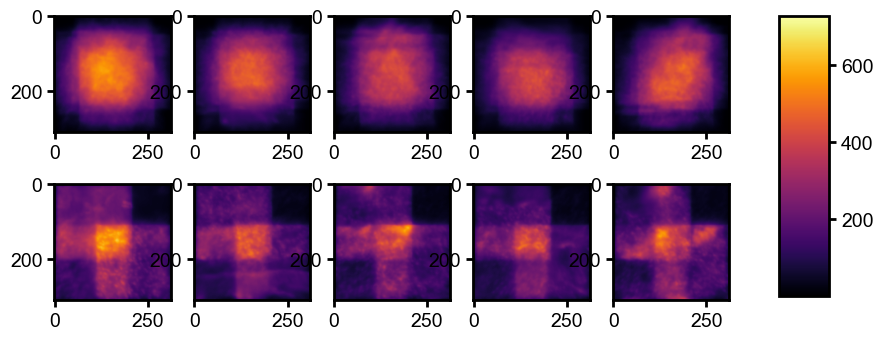

In [3]:
photon_count = 400

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [ ]:

# plot the histograms of the initial and final measurements
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(data_min, data_max, 80)

_ = axs.hist(initial_images[:10].ravel(), bins=bins, alpha=0.5)
_ = axs.hist(final_images[:10].ravel(), bins=bins, alpha=0.5)

# patches from everywhere

In [9]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [01:03<00:00, 78.42it/s] 


Initial validation NLL: 68.71


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Epoch 1: validation NLL: 5.55


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 35.07it/s]


Epoch 2: validation NLL: 5.21


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 37.60it/s]


Epoch 3: validation NLL: 4.39


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 36.97it/s]


Epoch 4: validation NLL: 4.21


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 37.05it/s]


Epoch 5: validation NLL: 4.27


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


Epoch 6: validation NLL: 4.15


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 36.76it/s]


Epoch 7: validation NLL: 4.17


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 36.62it/s]


Epoch 8: validation NLL: 4.20


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 37.03it/s]


Epoch 9: validation NLL: 4.10


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


Epoch 10: validation NLL: 4.15


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 36.26it/s]


Epoch 11: validation NLL: 4.10


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


Epoch 12: validation NLL: 4.26


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 31.01it/s]


Epoch 13: validation NLL: 4.19


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 31.13it/s]


Epoch 14: validation NLL: 4.11


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


Epoch 15: validation NLL: 4.13


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 31.79it/s]


Epoch 16: validation NLL: 4.09


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 31.41it/s]


Epoch 17: validation NLL: 4.11


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Epoch 18: validation NLL: 4.08


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


Epoch 19: validation NLL: 4.10


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


Epoch 20: validation NLL: 4.23


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 31.08it/s]


Epoch 21: validation NLL: 4.33


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 22: validation NLL: 4.10


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


Epoch 23: validation NLL: 4.90


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Epoch 24: validation NLL: 6.06


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


Epoch 25: validation NLL: 6.06


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 31.33it/s]


Epoch 26: validation NLL: 6.06


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 31.18it/s]


Epoch 27: validation NLL: 6.06


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 28: validation NLL: 6.06


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Epoch 29: validation NLL: 6.06


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


Epoch 30: validation NLL: 6.06


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 31.15it/s]


Epoch 31: validation NLL: 6.06


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 31.31it/s]


Epoch 32: validation NLL: 6.06


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 31.50it/s]


Epoch 33: validation NLL: 6.06


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 31.36it/s]


Epoch 34: validation NLL: 6.06


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 31.56it/s]


Epoch 35: validation NLL: 6.06


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


Epoch 36: validation NLL: 6.06


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 31.22it/s]


Epoch 37: validation NLL: 6.06


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 31.42it/s]


Epoch 38: validation NLL: 6.06


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 31.16it/s]


Epoch 39: validation NLL: 6.06


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 31.30it/s]


Epoch 40: validation NLL: 6.06


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 31.09it/s]


Epoch 41: validation NLL: 6.06


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


Epoch 42: validation NLL: 6.06


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 31.52it/s]


Epoch 43: validation NLL: 6.06


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


Epoch 44: validation NLL: 6.06


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 31.24it/s]


Epoch 45: validation NLL: 6.06


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


Epoch 46: validation NLL: 6.06


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


Epoch 47: validation NLL: 6.06


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 32.46it/s]


Epoch 48: validation NLL: 6.06


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 32.27it/s]


Epoch 49: validation NLL: 6.06


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Epoch 50: validation NLL: 6.06


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


Epoch 51: validation NLL: 6.06


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 40.69it/s]


Epoch 52: validation NLL: 6.06


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 40.99it/s]


Epoch 53: validation NLL: 6.06


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 40.89it/s]


Epoch 54: validation NLL: 6.06


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 40.86it/s]


Epoch 55: validation NLL: 6.06


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 56: validation NLL: 6.06


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


Epoch 57: validation NLL: 6.06


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 58: validation NLL: 6.06
Estimated H(Y|X) = 3.897 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.115 differential entropy/pixel
Estimated I(Y;X) = 0.314 bits/pixel
Initial validation NLL: 55.70


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


Epoch 1: validation NLL: 5.27


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Epoch 2: validation NLL: 5.14


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.05it/s]


Epoch 3: validation NLL: 5.34


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 38.73it/s]


Epoch 4: validation NLL: 4.13


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 38.84it/s]


Epoch 5: validation NLL: 4.10


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 40.19it/s]


Epoch 6: validation NLL: 4.10


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 7: validation NLL: 4.06


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 8: validation NLL: 4.04


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 9: validation NLL: 4.04


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 40.85it/s]


Epoch 10: validation NLL: 4.04


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 40.54it/s]


Epoch 11: validation NLL: 4.48


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 40.65it/s]


Epoch 12: validation NLL: 4.08


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 38.84it/s]


Epoch 13: validation NLL: 4.06


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Epoch 14: validation NLL: 4.03


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


Epoch 15: validation NLL: 4.33


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Epoch 16: validation NLL: 4.10


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


Epoch 17: validation NLL: 4.05


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 37.30it/s]


Epoch 18: validation NLL: 4.17


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 37.58it/s]


Epoch 19: validation NLL: 4.16


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 36.99it/s]


Epoch 20: validation NLL: 4.03


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 38.13it/s]


Epoch 21: validation NLL: 4.09


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 37.06it/s]


Epoch 22: validation NLL: 4.08


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.23it/s]


Epoch 23: validation NLL: 4.07


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 37.30it/s]


Epoch 24: validation NLL: 4.03


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


Epoch 25: validation NLL: 4.04


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 26: validation NLL: 4.03


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 37.23it/s]


Epoch 27: validation NLL: 4.02


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.88it/s]


Epoch 28: validation NLL: 4.04


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Epoch 29: validation NLL: 4.06


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 40.76it/s]


Epoch 30: validation NLL: 4.08


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 40.98it/s]


Epoch 31: validation NLL: 4.01


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 32: validation NLL: 4.02


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 33: validation NLL: 4.03


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


Epoch 34: validation NLL: 4.12


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 40.92it/s]


Epoch 35: validation NLL: 4.00


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


Epoch 36: validation NLL: 4.05


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 37: validation NLL: 4.04


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 38: validation NLL: 4.01


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Epoch 39: validation NLL: 4.02


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 40.39it/s]


Epoch 40: validation NLL: 4.01


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 41: validation NLL: 4.00


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 40.79it/s]


Epoch 42: validation NLL: 4.05


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 40.53it/s]


Epoch 43: validation NLL: 4.02


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 40.94it/s]


Epoch 44: validation NLL: 4.07


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch 45: validation NLL: 4.25


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 40.59it/s]


Epoch 46: validation NLL: 4.01


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 40.56it/s]


Epoch 47: validation NLL: 4.01


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 40.92it/s]


Epoch 48: validation NLL: 4.04


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 40.17it/s]


Epoch 49: validation NLL: 4.01


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 40.85it/s]


Epoch 50: validation NLL: 4.01


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


Epoch 51: validation NLL: 4.03


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 40.88it/s]


Epoch 52: validation NLL: 4.02


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 40.90it/s]


Epoch 53: validation NLL: 4.00


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


Epoch 54: validation NLL: 4.01


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 40.30it/s]


Epoch 55: validation NLL: 4.00


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 40.98it/s]


Epoch 56: validation NLL: 4.08


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 40.94it/s]


Epoch 57: validation NLL: 4.04


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


Epoch 58: validation NLL: 4.01


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 40.78it/s]


Epoch 59: validation NLL: 4.06


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


Epoch 60: validation NLL: 4.00


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 61: validation NLL: 4.00


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 40.86it/s]


Epoch 62: validation NLL: 4.01


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 63: validation NLL: 4.03


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 40.81it/s]


Epoch 64: validation NLL: 4.06


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


Epoch 65: validation NLL: 4.15


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Epoch 66: validation NLL: 4.00


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 67: validation NLL: 4.00


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch 68: validation NLL: 4.03


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


Epoch 69: validation NLL: 4.01


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 70: validation NLL: 4.02


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 40.97it/s]


Epoch 71: validation NLL: 4.01


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 41.00it/s]


Epoch 72: validation NLL: 4.03


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


Epoch 73: validation NLL: 4.04


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Epoch 74: validation NLL: 4.00


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 40.60it/s]


Epoch 75: validation NLL: 4.00


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 41.09it/s]


Epoch 76: validation NLL: 4.04


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 77: validation NLL: 4.00


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


Epoch 78: validation NLL: 4.00


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 40.76it/s]


Epoch 79: validation NLL: 4.02


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 80: validation NLL: 4.03


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Epoch 81: validation NLL: 4.00


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 41.02it/s]


Epoch 82: validation NLL: 4.02


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Epoch 83: validation NLL: 4.00


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 40.88it/s]


Epoch 84: validation NLL: 4.02


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 41.09it/s]


Epoch 85: validation NLL: 4.00


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 41.26it/s]


Epoch 86: validation NLL: 4.00


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Epoch 87: validation NLL: 4.04


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 41.19it/s]


Epoch 88: validation NLL: 4.00


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 41.11it/s]


Epoch 89: validation NLL: 4.13


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 40.98it/s]


Epoch 90: validation NLL: 4.02


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 91: validation NLL: 4.00


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 41.19it/s]


Epoch 92: validation NLL: 4.00


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


Epoch 93: validation NLL: 4.01


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 94: validation NLL: 4.01


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 41.02it/s]


Epoch 95: validation NLL: 4.00


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 41.18it/s]


Epoch 96: validation NLL: 4.02


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 97: validation NLL: 4.00


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 41.08it/s]


Epoch 98: validation NLL: 4.01


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 41.20it/s]


Epoch 99: validation NLL: 4.03


Epoch 100: 100%|██████████| 100/100 [00:02<00:00, 41.22it/s]


Epoch 100: validation NLL: 4.00


Epoch 101: 100%|██████████| 100/100 [00:02<00:00, 41.09it/s]


Epoch 101: validation NLL: 4.00


Epoch 102: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Epoch 102: validation NLL: 4.08


Epoch 103: 100%|██████████| 100/100 [00:02<00:00, 41.14it/s]


Epoch 103: validation NLL: 4.00


Epoch 104: 100%|██████████| 100/100 [00:02<00:00, 41.13it/s]


Epoch 104: validation NLL: 4.03


Epoch 105: 100%|██████████| 100/100 [00:02<00:00, 40.71it/s]


Epoch 105: validation NLL: 4.00


Epoch 106: 100%|██████████| 100/100 [00:02<00:00, 40.34it/s]


Epoch 106: validation NLL: 4.00


Epoch 107: 100%|██████████| 100/100 [00:02<00:00, 40.27it/s]


Epoch 107: validation NLL: 4.00


Epoch 108: 100%|██████████| 100/100 [00:02<00:00, 41.30it/s]


Epoch 108: validation NLL: 4.04


Epoch 109: 100%|██████████| 100/100 [00:02<00:00, 40.12it/s]


Epoch 109: validation NLL: 4.04


Epoch 110: 100%|██████████| 100/100 [00:02<00:00, 40.61it/s]


Epoch 110: validation NLL: 4.00


Epoch 111: 100%|██████████| 100/100 [00:02<00:00, 40.92it/s]


Epoch 111: validation NLL: 4.01


Epoch 112: 100%|██████████| 100/100 [00:02<00:00, 40.57it/s]


Epoch 112: validation NLL: 4.01


Epoch 113: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 113: validation NLL: 4.01


Epoch 114: 100%|██████████| 100/100 [00:02<00:00, 38.03it/s]


Epoch 114: validation NLL: 4.01


Epoch 115: 100%|██████████| 100/100 [00:02<00:00, 40.62it/s]


Epoch 115: validation NLL: 4.02


Epoch 116: 100%|██████████| 100/100 [00:02<00:00, 41.10it/s]


Epoch 116: validation NLL: 4.00


Epoch 117: 100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


Epoch 117: validation NLL: 4.11


Epoch 118: 100%|██████████| 100/100 [00:02<00:00, 41.15it/s]


Epoch 118: validation NLL: 4.00


Epoch 119: 100%|██████████| 100/100 [00:02<00:00, 41.11it/s]


Epoch 119: validation NLL: 4.01


Epoch 120: 100%|██████████| 100/100 [00:02<00:00, 40.90it/s]


Epoch 120: validation NLL: 4.00


Epoch 121: 100%|██████████| 100/100 [00:02<00:00, 40.82it/s]


Epoch 121: validation NLL: 4.02


Epoch 122: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Epoch 122: validation NLL: 4.00


Epoch 123: 100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


Epoch 123: validation NLL: 4.00


Epoch 124: 100%|██████████| 100/100 [00:02<00:00, 41.11it/s]


Epoch 124: validation NLL: 4.00


Epoch 125: 100%|██████████| 100/100 [00:02<00:00, 41.35it/s]


Epoch 125: validation NLL: 4.00
Estimated H(Y|X) = 3.923 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.033 differential entropy/pixel
Estimated I(Y;X) = 0.159 bits/pixel
Initial MI:  0.31435022
Final MI:  0.15851778


```
Initial MI:  0.31435022
Final MI:  0.15851778
```

### Replicate

In [4]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:38<00:00, 130.03it/s]
2024-01-23 10:16:24.884872: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 74.07


Epoch 1: 100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 1: validation NLL: 5.25


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 36.33it/s]


Epoch 2: validation NLL: 4.51


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.31it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 37.87it/s]


Epoch 4: validation NLL: 4.34


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 38.18it/s]


Epoch 5: validation NLL: 4.17


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s]


Epoch 6: validation NLL: 4.13


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Epoch 7: validation NLL: 4.17


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 8: validation NLL: 4.12


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 9: validation NLL: 4.24


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 10: validation NLL: 4.09


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 37.99it/s]


Epoch 11: validation NLL: 4.51


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


Epoch 12: validation NLL: 5.12


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 38.39it/s]


Epoch 13: validation NLL: 4.28


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


Epoch 14: validation NLL: 4.23


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


Epoch 15: validation NLL: 4.14


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


Epoch 16: validation NLL: 4.98


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 38.60it/s]


Epoch 17: validation NLL: 4.76


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


Epoch 18: validation NLL: 4.11


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 19: validation NLL: 4.20


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


Epoch 20: validation NLL: 4.30


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 38.33it/s]


Epoch 21: validation NLL: 4.15


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


Epoch 22: validation NLL: 4.19


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.07it/s]


Epoch 23: validation NLL: 4.09


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


Epoch 24: validation NLL: 4.92


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 38.14it/s]


Epoch 25: validation NLL: 4.41


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 38.00it/s]


Epoch 26: validation NLL: 4.08


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


Epoch 27: validation NLL: 4.11


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Epoch 28: validation NLL: 4.22


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 38.84it/s]


Epoch 29: validation NLL: 4.34


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 30: validation NLL: 4.30


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 31: validation NLL: 4.12


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch 32: validation NLL: 4.09


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 33: validation NLL: 4.15


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 34: validation NLL: 4.09


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Epoch 35: validation NLL: 4.40


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 36: validation NLL: 4.12


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Epoch 37: validation NLL: 4.08


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.96it/s]


Epoch 38: validation NLL: 4.14


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.39it/s]


Epoch 39: validation NLL: 4.18


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.81it/s]


Epoch 40: validation NLL: 4.08


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 38.89it/s]


Epoch 41: validation NLL: 4.11


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 42: validation NLL: 4.17


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 43: validation NLL: 4.10


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


Epoch 44: validation NLL: 4.17


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 45: validation NLL: 4.15


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 46: validation NLL: 4.34


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 47: validation NLL: 4.12


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 48: validation NLL: 4.23


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Epoch 49: validation NLL: 4.13


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 40.14it/s]


Epoch 50: validation NLL: 4.30


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.51it/s]


Epoch 51: validation NLL: 4.10


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 52: validation NLL: 4.08


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


Epoch 53: validation NLL: 4.09


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 38.31it/s]


Epoch 54: validation NLL: 4.20


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 55: validation NLL: 4.11


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Epoch 56: validation NLL: 4.10


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 57: validation NLL: 5.29


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 58: validation NLL: 4.24


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


Epoch 59: validation NLL: 4.21


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 60: validation NLL: 4.41


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 38.79it/s]


Epoch 61: validation NLL: 4.19


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


Epoch 62: validation NLL: 4.13


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 63: validation NLL: 4.12


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 38.46it/s]


Epoch 64: validation NLL: 4.18


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


Epoch 65: validation NLL: 4.20


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 38.49it/s]


Epoch 66: validation NLL: 4.17


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 67: validation NLL: 4.18


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 38.50it/s]


Epoch 68: validation NLL: 4.08


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 37.64it/s]


Epoch 69: validation NLL: 4.09


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 38.78it/s]


Epoch 70: validation NLL: 4.12


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 38.73it/s]


Epoch 71: validation NLL: 4.16


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 38.33it/s]


Epoch 72: validation NLL: 4.15


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Epoch 73: validation NLL: 4.65


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


Epoch 74: validation NLL: 4.10


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 38.81it/s]


Epoch 75: validation NLL: 4.25


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 76: validation NLL: 4.25


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 38.49it/s]


Epoch 77: validation NLL: 4.27


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


Epoch 78: validation NLL: 4.25


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 38.55it/s]


Epoch 79: validation NLL: 4.11


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Epoch 80: validation NLL: 4.80


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 38.50it/s]


Epoch 81: validation NLL: 5.52


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 82: validation NLL: 5.15


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 38.87it/s]


Epoch 83: validation NLL: 4.35


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


Epoch 84: validation NLL: 4.25


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 38.51it/s]


Epoch 85: validation NLL: 4.26


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


Epoch 86: validation NLL: 4.31


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 87: validation NLL: 4.20


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 88: validation NLL: 4.22


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Epoch 89: validation NLL: 4.18


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


Epoch 90: validation NLL: 4.17


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


Epoch 91: validation NLL: 4.19


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s]


Epoch 92: validation NLL: 4.19
Estimated H(Y|X) = 3.894 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.059 differential entropy/pixel
Estimated I(Y;X) = 0.239 bits/pixel
Initial validation NLL: 43.57


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 2: validation NLL: 4.17


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 3: validation NLL: 4.32


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 4: validation NLL: 4.18


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 5: validation NLL: 4.12


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Epoch 6: validation NLL: 4.19


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Epoch 7: validation NLL: 4.23


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 8: validation NLL: 4.28


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 9: validation NLL: 4.31


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 10: validation NLL: 4.30


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 11: validation NLL: 4.12


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 12: validation NLL: 4.51


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.39it/s]


Epoch 13: validation NLL: 4.09


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


Epoch 14: validation NLL: 4.08


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 15: validation NLL: 4.15


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 16: validation NLL: 4.08


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 17: validation NLL: 4.08


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 18: validation NLL: 4.09


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


Epoch 19: validation NLL: 4.08


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 20: validation NLL: 4.12


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 21: validation NLL: 4.19


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 22: validation NLL: 4.11


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 23: validation NLL: 4.09


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 24: validation NLL: 4.08


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


Epoch 25: validation NLL: 4.08


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Epoch 26: validation NLL: 4.09


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 27: validation NLL: 4.10


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 28: validation NLL: 4.17


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.89it/s]


Epoch 29: validation NLL: 4.12


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 30: validation NLL: 4.06


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.94it/s]


Epoch 31: validation NLL: 4.08


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 32: validation NLL: 4.45


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 33: validation NLL: 4.20


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 34: validation NLL: 4.13


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 35: validation NLL: 4.09


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


Epoch 36: validation NLL: 4.10


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 37: validation NLL: 4.08


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 38: validation NLL: 4.08


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 39: validation NLL: 4.09


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch 40: validation NLL: 4.20


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch 41: validation NLL: 4.07


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 40.39it/s]


Epoch 42: validation NLL: 4.06


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.08it/s]


Epoch 43: validation NLL: 4.08


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 44: validation NLL: 4.06


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 45: validation NLL: 4.12


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 46: validation NLL: 4.11


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Epoch 47: validation NLL: 4.08


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Epoch 48: validation NLL: 4.07


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 49: validation NLL: 4.06


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 50: validation NLL: 4.06


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 51: validation NLL: 4.07


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 52: validation NLL: 4.09


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 40.21it/s]


Epoch 53: validation NLL: 4.07


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 54: validation NLL: 4.09


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 55: validation NLL: 4.05


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 56: validation NLL: 4.09


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 57: validation NLL: 4.06


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 58: validation NLL: 4.08


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 59: validation NLL: 4.07


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 60: validation NLL: 4.13


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Epoch 61: validation NLL: 4.19


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 62: validation NLL: 4.08


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 63: validation NLL: 4.11


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 64: validation NLL: 4.08


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch 65: validation NLL: 4.09


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Epoch 66: validation NLL: 4.06


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 67: validation NLL: 4.49


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 68: validation NLL: 4.13


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Epoch 69: validation NLL: 4.11


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Epoch 70: validation NLL: 4.06


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 40.05it/s]


Epoch 71: validation NLL: 4.07


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 40.21it/s]


Epoch 72: validation NLL: 4.07


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 40.04it/s]


Epoch 73: validation NLL: 4.09


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 74: validation NLL: 4.07


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 75: validation NLL: 4.07


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 39.89it/s]


Epoch 76: validation NLL: 4.12


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch 77: validation NLL: 4.07


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 78: validation NLL: 4.07


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 79: validation NLL: 4.05


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Epoch 80: validation NLL: 4.10


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 81: validation NLL: 4.07


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 82: validation NLL: 4.08


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Epoch 83: validation NLL: 4.07


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


Epoch 84: validation NLL: 4.08


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 85: validation NLL: 4.06


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


Epoch 86: validation NLL: 4.06


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


Epoch 87: validation NLL: 4.05


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


Epoch 88: validation NLL: 4.09


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 89: validation NLL: 4.07


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 90: validation NLL: 4.07


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 39.25it/s]


Epoch 91: validation NLL: 4.05


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 92: validation NLL: 4.06


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 39.88it/s]


Epoch 93: validation NLL: 4.04


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


Epoch 94: validation NLL: 4.09


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 38.43it/s]


Epoch 95: validation NLL: 4.05


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


Epoch 96: validation NLL: 4.06


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 37.90it/s]


Epoch 97: validation NLL: 4.06


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Epoch 98: validation NLL: 4.06


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 99: validation NLL: 4.06


Epoch 100: 100%|██████████| 100/100 [00:02<00:00, 37.72it/s]


Epoch 100: validation NLL: 4.05


Epoch 101: 100%|██████████| 100/100 [00:02<00:00, 37.92it/s]


Epoch 101: validation NLL: 4.05


Epoch 102: 100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


Epoch 102: validation NLL: 4.11


Epoch 103: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


Epoch 103: validation NLL: 4.05


Epoch 104: 100%|██████████| 100/100 [00:02<00:00, 37.54it/s]


Epoch 104: validation NLL: 4.07


Epoch 105: 100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


Epoch 105: validation NLL: 4.06


Epoch 106: 100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


Epoch 106: validation NLL: 4.05


Epoch 107: 100%|██████████| 100/100 [00:02<00:00, 38.36it/s]


Epoch 107: validation NLL: 4.05


Epoch 108: 100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


Epoch 108: validation NLL: 4.08


Epoch 109: 100%|██████████| 100/100 [00:02<00:00, 38.02it/s]


Epoch 109: validation NLL: 4.06


Epoch 110: 100%|██████████| 100/100 [00:02<00:00, 38.02it/s]


Epoch 110: validation NLL: 4.07


Epoch 111: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


Epoch 111: validation NLL: 4.05


Epoch 112: 100%|██████████| 100/100 [00:02<00:00, 37.97it/s]


Epoch 112: validation NLL: 4.09


Epoch 113: 100%|██████████| 100/100 [00:02<00:00, 38.71it/s]


Epoch 113: validation NLL: 4.07


Epoch 114: 100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


Epoch 114: validation NLL: 4.04


Epoch 115: 100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


Epoch 115: validation NLL: 4.07


Epoch 116: 100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Epoch 116: validation NLL: 4.04


Epoch 117: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Epoch 117: validation NLL: 4.06


Epoch 118: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 118: validation NLL: 4.06


Epoch 119: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 119: validation NLL: 4.05


Epoch 120: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 120: validation NLL: 4.05


Epoch 121: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Epoch 121: validation NLL: 4.04


Epoch 122: 100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch 122: validation NLL: 4.04


Epoch 123: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 123: validation NLL: 4.04


Epoch 124: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 124: validation NLL: 4.06


Epoch 125: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 125: validation NLL: 4.05


Epoch 126: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 126: validation NLL: 4.08


Epoch 127: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


Epoch 127: validation NLL: 4.05


Epoch 128: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 128: validation NLL: 4.06


Epoch 129: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 129: validation NLL: 4.05


Epoch 130: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 130: validation NLL: 4.07


Epoch 131: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 131: validation NLL: 4.06


Epoch 132: 100%|██████████| 100/100 [00:02<00:00, 39.25it/s]


Epoch 132: validation NLL: 4.06


Epoch 133: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 133: validation NLL: 4.06


Epoch 134: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 134: validation NLL: 4.05


Epoch 135: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 135: validation NLL: 4.04


Epoch 136: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 136: validation NLL: 4.05


Epoch 137: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 137: validation NLL: 4.05


Epoch 138: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 138: validation NLL: 4.06


Epoch 139: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 139: validation NLL: 4.05


Epoch 140: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 140: validation NLL: 4.04


Epoch 141: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 141: validation NLL: 4.04


Epoch 142: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 142: validation NLL: 4.05


Epoch 143: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 143: validation NLL: 4.04


Epoch 144: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 144: validation NLL: 4.06


Epoch 145: 100%|██████████| 100/100 [00:02<00:00, 38.39it/s]


Epoch 145: validation NLL: 4.04


Epoch 146: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


Epoch 146: validation NLL: 4.04


Epoch 147: 100%|██████████| 100/100 [00:02<00:00, 38.43it/s]


Epoch 147: validation NLL: 4.04


Epoch 148: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


Epoch 148: validation NLL: 4.04


Epoch 149: 100%|██████████| 100/100 [00:02<00:00, 38.43it/s]


Epoch 149: validation NLL: 4.06


Epoch 150: 100%|██████████| 100/100 [00:02<00:00, 38.69it/s]


Epoch 150: validation NLL: 4.05


Epoch 151: 100%|██████████| 100/100 [00:02<00:00, 37.99it/s]


Epoch 151: validation NLL: 4.05


Epoch 152: 100%|██████████| 100/100 [00:02<00:00, 37.82it/s]


Epoch 152: validation NLL: 4.05


Epoch 153: 100%|██████████| 100/100 [00:02<00:00, 38.71it/s]


Epoch 153: validation NLL: 4.04


Epoch 154: 100%|██████████| 100/100 [00:02<00:00, 38.06it/s]


Epoch 154: validation NLL: 4.06


Epoch 155: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 155: validation NLL: 4.04


Epoch 156: 100%|██████████| 100/100 [00:02<00:00, 38.29it/s]


Epoch 156: validation NLL: 4.05


Epoch 157: 100%|██████████| 100/100 [00:02<00:00, 38.27it/s]


Epoch 157: validation NLL: 4.07


Epoch 158: 100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch 158: validation NLL: 4.05


Epoch 159: 100%|██████████| 100/100 [00:02<00:00, 37.97it/s]


Epoch 159: validation NLL: 4.06


Epoch 160: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 160: validation NLL: 4.05


Epoch 161: 100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


Epoch 161: validation NLL: 4.04


Epoch 162: 100%|██████████| 100/100 [00:02<00:00, 38.29it/s]


Epoch 162: validation NLL: 4.07


Epoch 163: 100%|██████████| 100/100 [00:02<00:00, 38.46it/s]


Epoch 163: validation NLL: 4.06


Epoch 164: 100%|██████████| 100/100 [00:02<00:00, 38.12it/s]


Epoch 164: validation NLL: 4.10


Epoch 165: 100%|██████████| 100/100 [00:02<00:00, 38.25it/s]


Epoch 165: validation NLL: 4.05


Epoch 166: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 166: validation NLL: 4.04


Epoch 167: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 167: validation NLL: 4.04


Epoch 168: 100%|██████████| 100/100 [00:02<00:00, 38.50it/s]


Epoch 168: validation NLL: 4.04


Epoch 169: 100%|██████████| 100/100 [00:02<00:00, 38.13it/s]


Epoch 169: validation NLL: 4.04


Epoch 170: 100%|██████████| 100/100 [00:02<00:00, 37.95it/s]


Epoch 170: validation NLL: 4.05


Epoch 171: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Epoch 171: validation NLL: 4.05


Epoch 172: 100%|██████████| 100/100 [00:02<00:00, 38.15it/s]


Epoch 172: validation NLL: 4.21


Epoch 173: 100%|██████████| 100/100 [00:02<00:00, 38.69it/s]


Epoch 173: validation NLL: 5.83


Epoch 174: 100%|██████████| 100/100 [00:02<00:00, 38.15it/s]


Epoch 174: validation NLL: 5.83


Epoch 175: 100%|██████████| 100/100 [00:02<00:00, 38.28it/s]


Epoch 175: validation NLL: 5.83


Epoch 176: 100%|██████████| 100/100 [00:02<00:00, 38.37it/s]


Epoch 176: validation NLL: 5.83


Epoch 177: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Epoch 177: validation NLL: 5.83


Epoch 178: 100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


Epoch 178: validation NLL: 5.83


Epoch 179: 100%|██████████| 100/100 [00:02<00:00, 38.13it/s]


Epoch 179: validation NLL: 5.82


Epoch 180: 100%|██████████| 100/100 [00:02<00:00, 38.42it/s]


Epoch 180: validation NLL: 5.82


Epoch 181: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 181: validation NLL: 5.82


Epoch 182: 100%|██████████| 100/100 [00:02<00:00, 37.97it/s]


Epoch 182: validation NLL: 5.82


Epoch 183: 100%|██████████| 100/100 [00:02<00:00, 37.49it/s]


Epoch 183: validation NLL: 5.82
Estimated H(Y|X) = 3.936 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.021 differential entropy/pixel
Estimated I(Y;X) = 0.123 bits/pixel
Initial MI:  0.2390373
Final MI:  0.12330158


```
Initial MI:  0.2390373
Final MI:  0.12330158
```

### Replicate

In [5]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:39<00:00, 125.12it/s]


Initial validation NLL: 69.18


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Epoch 1: validation NLL: 5.45


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 36.51it/s]


Epoch 2: validation NLL: 5.32


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 3: validation NLL: 4.80


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 4: validation NLL: 4.19


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


Epoch 6: validation NLL: 4.39


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


Epoch 7: validation NLL: 4.45


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.87it/s]


Epoch 9: validation NLL: 4.16


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 10: validation NLL: 4.16


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


Epoch 11: validation NLL: 4.08


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 12: validation NLL: 4.31


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 13: validation NLL: 4.18


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 14: validation NLL: 4.06


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 15: validation NLL: 4.05


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


Epoch 16: validation NLL: 4.15


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


Epoch 17: validation NLL: 4.07


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 18: validation NLL: 4.14


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


Epoch 19: validation NLL: 4.08


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 20: validation NLL: 4.14


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 21: validation NLL: 4.10


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 22: validation NLL: 4.06


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


Epoch 23: validation NLL: 4.33


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 24: validation NLL: 4.07


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 25: validation NLL: 4.18


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 26: validation NLL: 4.23


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 27: validation NLL: 4.47


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 28: validation NLL: 4.20


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 29: validation NLL: 4.05


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 30: validation NLL: 4.49


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 38.89it/s]


Epoch 31: validation NLL: 4.06


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 32: validation NLL: 4.05


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.82it/s]


Epoch 33: validation NLL: 4.12


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 34: validation NLL: 4.09


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 38.78it/s]


Epoch 35: validation NLL: 4.03


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 36: validation NLL: 4.05


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 37: validation NLL: 4.12


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.07it/s]


Epoch 38: validation NLL: 4.24


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


Epoch 39: validation NLL: 4.04


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 40: validation NLL: 4.08


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 41: validation NLL: 4.04


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 42: validation NLL: 4.08


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 43: validation NLL: 4.06


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 44: validation NLL: 4.05


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 45: validation NLL: 4.87


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 46: validation NLL: 4.06


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 47: validation NLL: 4.05


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 48: validation NLL: 4.10


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 49: validation NLL: 4.07


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 50: validation NLL: 4.05


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 51: validation NLL: 4.02


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


Epoch 52: validation NLL: 4.20


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 53: validation NLL: 4.08


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 54: validation NLL: 4.11


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 55: validation NLL: 4.06


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Epoch 56: validation NLL: 4.03


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 57: validation NLL: 4.06


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Epoch 58: validation NLL: 4.05


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 59: validation NLL: 4.12


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Epoch 60: validation NLL: 4.07


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 61: validation NLL: 4.02


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 62: validation NLL: 4.06


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Epoch 63: validation NLL: 4.05


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Epoch 64: validation NLL: 4.02


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Epoch 65: validation NLL: 4.04


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch 66: validation NLL: 4.03


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 39.25it/s]


Epoch 67: validation NLL: 4.11


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 68: validation NLL: 4.06


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


Epoch 69: validation NLL: 4.12


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 70: validation NLL: 4.04


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 71: validation NLL: 4.85


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


Epoch 72: validation NLL: 4.44


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 73: validation NLL: 4.61


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 39.39it/s]


Epoch 74: validation NLL: 4.08


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 75: validation NLL: 4.06


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 76: validation NLL: 4.45


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 77: validation NLL: 4.06


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 40.02it/s]


Epoch 78: validation NLL: 4.09


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 79: validation NLL: 4.07


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 40.17it/s]


Epoch 80: validation NLL: 4.04


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 81: validation NLL: 4.09


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


Epoch 82: validation NLL: 4.06


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 83: validation NLL: 4.14


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 84: validation NLL: 4.17


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 85: validation NLL: 4.07


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 86: validation NLL: 4.06


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 87: validation NLL: 4.10


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 88: validation NLL: 4.06


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 89: validation NLL: 4.03


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 90: validation NLL: 4.05


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 91: validation NLL: 4.24


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 92: validation NLL: 4.06


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 40.08it/s]


Epoch 93: validation NLL: 4.04


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 40.13it/s]


Epoch 94: validation NLL: 4.03


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 95: validation NLL: 4.10


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 96: validation NLL: 4.13


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 97: validation NLL: 4.02


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 38.73it/s]


Epoch 98: validation NLL: 4.03


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 99: validation NLL: 4.06


Epoch 100: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 100: validation NLL: 4.06


Epoch 101: 100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


Epoch 101: validation NLL: 4.04


Epoch 102: 100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


Epoch 102: validation NLL: 4.04


Epoch 103: 100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


Epoch 103: validation NLL: 4.11


Epoch 104: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 104: validation NLL: 4.05
Estimated H(Y|X) = 3.895 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.052 differential entropy/pixel
Estimated I(Y;X) = 0.226 bits/pixel
Initial validation NLL: 54.65


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Epoch 1: validation NLL: 5.44


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 36.97it/s]


Epoch 2: validation NLL: 4.36


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 3: validation NLL: 4.45


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 4: validation NLL: 4.54


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 5: validation NLL: 4.19


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.81it/s]


Epoch 6: validation NLL: 4.11


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 7: validation NLL: 6.11


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Epoch 8: validation NLL: 4.25


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.90it/s]


Epoch 9: validation NLL: 4.25


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch 10: validation NLL: 4.14


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 40.15it/s]


Epoch 11: validation NLL: 4.22


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 38.89it/s]


Epoch 12: validation NLL: 4.11


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 13: validation NLL: 4.19


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


Epoch 14: validation NLL: 4.11


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Epoch 15: validation NLL: 4.07


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.37it/s]


Epoch 16: validation NLL: 4.06


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 17: validation NLL: 4.12


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 18: validation NLL: 4.04


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 19: validation NLL: 4.06


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 20: validation NLL: 4.08


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 21: validation NLL: 4.13


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


Epoch 22: validation NLL: 4.04


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


Epoch 23: validation NLL: 4.03


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 24: validation NLL: 4.06


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 25: validation NLL: 4.05


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


Epoch 26: validation NLL: 4.16


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 38.81it/s]


Epoch 27: validation NLL: 4.04


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 28: validation NLL: 4.07


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


Epoch 29: validation NLL: 4.04


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


Epoch 30: validation NLL: 4.28


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


Epoch 31: validation NLL: 4.08


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 32: validation NLL: 4.04


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 33: validation NLL: 4.07


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 34: validation NLL: 4.10


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.25it/s]


Epoch 35: validation NLL: 4.08


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 36: validation NLL: 4.04


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 37: validation NLL: 4.09


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 38: validation NLL: 4.03


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 38.90it/s]


Epoch 39: validation NLL: 4.08


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


Epoch 40: validation NLL: 4.08


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 41: validation NLL: 4.03


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 42: validation NLL: 4.03


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 43: validation NLL: 4.08


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 44: validation NLL: 4.11


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 45: validation NLL: 4.05


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 46: validation NLL: 4.04


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 47: validation NLL: 4.10


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 48: validation NLL: 4.05


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 49: validation NLL: 4.03


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 50: validation NLL: 4.03


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 51: validation NLL: 4.06


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.08it/s]


Epoch 52: validation NLL: 4.09


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 53: validation NLL: 4.05


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Epoch 54: validation NLL: 4.05


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 55: validation NLL: 4.15


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Epoch 56: validation NLL: 4.10


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 57: validation NLL: 4.07


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Epoch 58: validation NLL: 4.02


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 59: validation NLL: 4.03


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 60: validation NLL: 4.05


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


Epoch 61: validation NLL: 4.04


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 62: validation NLL: 4.03


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 63: validation NLL: 4.03


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 64: validation NLL: 4.08


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 38.85it/s]


Epoch 65: validation NLL: 4.02


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 66: validation NLL: 4.03


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 67: validation NLL: 4.03


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 68: validation NLL: 4.08


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 69: validation NLL: 4.03


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 70: validation NLL: 4.07


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 71: validation NLL: 4.02


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 72: validation NLL: 4.06


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 73: validation NLL: 4.06


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 74: validation NLL: 4.05


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 75: validation NLL: 4.03


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 76: validation NLL: 4.06


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 77: validation NLL: 4.03


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 78: validation NLL: 4.03


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 79: validation NLL: 4.02


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 80: validation NLL: 4.04


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 81: validation NLL: 4.02


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch 82: validation NLL: 4.02


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 83: validation NLL: 4.06


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 84: validation NLL: 4.04


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch 85: validation NLL: 4.03


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 86: validation NLL: 4.03


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 87: validation NLL: 4.10


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 88: validation NLL: 4.06


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 39.92it/s]


Epoch 89: validation NLL: 4.03


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 90: validation NLL: 4.02


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 91: validation NLL: 4.01


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Epoch 92: validation NLL: 4.04


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 93: validation NLL: 4.02


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 94: validation NLL: 4.05


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 95: validation NLL: 4.04


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 96: validation NLL: 4.04


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 97: validation NLL: 4.03


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Epoch 98: validation NLL: 4.04


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 99: validation NLL: 4.03


Epoch 100: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 100: validation NLL: 4.03


Epoch 101: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 101: validation NLL: 4.02


Epoch 102: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 102: validation NLL: 4.04


Epoch 103: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 103: validation NLL: 4.02


Epoch 104: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 104: validation NLL: 4.02


Epoch 105: 100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


Epoch 105: validation NLL: 4.04


Epoch 106: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 106: validation NLL: 4.20


Epoch 107: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 107: validation NLL: 4.04


Epoch 108: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 108: validation NLL: 4.03


Epoch 109: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 109: validation NLL: 4.03


Epoch 110: 100%|██████████| 100/100 [00:02<00:00, 38.87it/s]


Epoch 110: validation NLL: 4.02


Epoch 111: 100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


Epoch 111: validation NLL: 4.02


Epoch 112: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 112: validation NLL: 4.02


Epoch 113: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 113: validation NLL: 4.03


Epoch 114: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 114: validation NLL: 4.04


Epoch 115: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 115: validation NLL: 4.02


Epoch 116: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 116: validation NLL: 4.04


Epoch 117: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 117: validation NLL: 4.02


Epoch 118: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 118: validation NLL: 4.02


Epoch 119: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 119: validation NLL: 4.02


Epoch 120: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 120: validation NLL: 4.03


Epoch 121: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 121: validation NLL: 4.06


Epoch 122: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 122: validation NLL: 4.03


Epoch 123: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 123: validation NLL: 4.03


Epoch 124: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 124: validation NLL: 4.10


Epoch 125: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 125: validation NLL: 4.03


Epoch 126: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 126: validation NLL: 4.05


Epoch 127: 100%|██████████| 100/100 [00:02<00:00, 39.01it/s]


Epoch 127: validation NLL: 4.03


Epoch 128: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 128: validation NLL: 4.02


Epoch 129: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 129: validation NLL: 4.03


Epoch 130: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 130: validation NLL: 4.03


Epoch 131: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 131: validation NLL: 4.03
Estimated H(Y|X) = 3.930 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.016 differential entropy/pixel
Estimated I(Y;X) = 0.125 bits/pixel
Initial MI:  0.22623491
Final MI:  0.124511994


```
Initial MI:  0.22623491
Final MI:  0.124511994
```

### Replicate

In [6]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:39<00:00, 125.81it/s]


Initial validation NLL: 70.62


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Epoch 1: validation NLL: 5.43


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 36.20it/s]


Epoch 2: validation NLL: 4.46


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


Epoch 3: validation NLL: 4.16


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


Epoch 4: validation NLL: 4.28


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 5: validation NLL: 4.29


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


Epoch 6: validation NLL: 5.06


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 7: validation NLL: 4.94


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 8: validation NLL: 5.56


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 9: validation NLL: 4.32


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


Epoch 10: validation NLL: 4.49


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 11: validation NLL: 4.25


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


Epoch 12: validation NLL: 4.23


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 14: validation NLL: 4.13


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch 15: validation NLL: 4.15


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 16: validation NLL: 4.09


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


Epoch 17: validation NLL: 4.22


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 38.89it/s]


Epoch 18: validation NLL: 4.08


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 19: validation NLL: 4.13


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 20: validation NLL: 4.10


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 21: validation NLL: 4.12


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Epoch 22: validation NLL: 4.26


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 23: validation NLL: 4.25


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 24: validation NLL: 4.15


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 25: validation NLL: 4.13


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 26: validation NLL: 4.21


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


Epoch 27: validation NLL: 4.08


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


Epoch 28: validation NLL: 4.08


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 29: validation NLL: 4.12


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 30: validation NLL: 4.41


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 31: validation NLL: 4.08


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 32: validation NLL: 4.07


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 33: validation NLL: 4.55


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch 34: validation NLL: 4.09


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 35: validation NLL: 5.18


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 36: validation NLL: 6.10


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 37: validation NLL: 6.00


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 38: validation NLL: 6.00


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 39: validation NLL: 6.00


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 40: validation NLL: 6.00


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 41: validation NLL: 6.00


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 42: validation NLL: 6.00


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 43: validation NLL: 6.00


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Epoch 44: validation NLL: 6.00


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Epoch 45: validation NLL: 6.00


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


Epoch 46: validation NLL: 6.00


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 47: validation NLL: 6.00


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 40.03it/s]


Epoch 48: validation NLL: 6.00


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 40.30it/s]


Epoch 49: validation NLL: 6.00


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Epoch 50: validation NLL: 6.00


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 51: validation NLL: 6.00


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 52: validation NLL: 6.00


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 40.11it/s]


Epoch 53: validation NLL: 6.00


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 40.62it/s]


Epoch 54: validation NLL: 6.00


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 40.13it/s]


Epoch 55: validation NLL: 6.00


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 40.40it/s]


Epoch 56: validation NLL: 6.00


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 40.78it/s]


Epoch 57: validation NLL: 6.00


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Epoch 58: validation NLL: 6.00


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 59: validation NLL: 6.00


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


Epoch 60: validation NLL: 6.00


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 37.06it/s]


Epoch 61: validation NLL: 6.00


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 36.92it/s]


Epoch 62: validation NLL: 6.00


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 37.72it/s]


Epoch 63: validation NLL: 6.00


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 37.68it/s]


Epoch 64: validation NLL: 6.00


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 33.54it/s]


Epoch 65: validation NLL: 6.00


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch 66: validation NLL: 6.00


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


Epoch 67: validation NLL: 6.00


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 68: validation NLL: 6.00


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Epoch 69: validation NLL: 6.00


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


Epoch 70: validation NLL: 6.00


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 40.86it/s]


Epoch 71: validation NLL: 6.00


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Epoch 72: validation NLL: 6.00
Estimated H(Y|X) = 3.909 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.068 differential entropy/pixel
Estimated I(Y;X) = 0.230 bits/pixel
Initial validation NLL: 51.83


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 1: validation NLL: 4.49


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 40.78it/s]


Epoch 2: validation NLL: 4.30


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


Epoch 3: validation NLL: 4.29


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


Epoch 4: validation NLL: 4.34


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.91it/s]


Epoch 5: validation NLL: 4.34


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 6: validation NLL: 4.37


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Epoch 7: validation NLL: 4.23


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 8: validation NLL: 4.16


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.98it/s]


Epoch 9: validation NLL: 4.22


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 10: validation NLL: 4.36


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 11: validation NLL: 4.32


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 12: validation NLL: 4.12


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Epoch 13: validation NLL: 4.13


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.89it/s]


Epoch 14: validation NLL: 4.13


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 15: validation NLL: 4.47


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 16: validation NLL: 4.15


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 17: validation NLL: 4.13


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 18: validation NLL: 4.14


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 19: validation NLL: 4.12


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 20: validation NLL: 4.12


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 21: validation NLL: 4.10


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 22: validation NLL: 4.15


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.79it/s]


Epoch 23: validation NLL: 4.11


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Epoch 24: validation NLL: 4.13


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


Epoch 25: validation NLL: 4.17


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 26: validation NLL: 4.10


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 27: validation NLL: 4.10


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 28: validation NLL: 4.10


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 29: validation NLL: 4.10


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 30: validation NLL: 4.11


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 31: validation NLL: 4.10


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 32: validation NLL: 4.20


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


Epoch 33: validation NLL: 4.27


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 40.04it/s]


Epoch 34: validation NLL: 4.10


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 35: validation NLL: 4.12


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 36: validation NLL: 4.11


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.92it/s]


Epoch 37: validation NLL: 4.17


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.93it/s]


Epoch 38: validation NLL: 4.14


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 39: validation NLL: 4.15


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 40: validation NLL: 4.10


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 40.08it/s]


Epoch 41: validation NLL: 4.10


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 42: validation NLL: 4.12


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 43: validation NLL: 4.10


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


Epoch 44: validation NLL: 4.14


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 45: validation NLL: 4.13


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 46: validation NLL: 4.09


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 47: validation NLL: 4.11


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


Epoch 48: validation NLL: 4.17


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.74it/s]


Epoch 49: validation NLL: 4.16


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Epoch 50: validation NLL: 4.09


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 51: validation NLL: 4.17


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Epoch 52: validation NLL: 4.22


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 40.00it/s]


Epoch 53: validation NLL: 4.33


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 54: validation NLL: 4.11


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


Epoch 55: validation NLL: 4.11


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 56: validation NLL: 4.09


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


Epoch 57: validation NLL: 4.10


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 58: validation NLL: 4.10


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.93it/s]


Epoch 59: validation NLL: 4.65


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


Epoch 60: validation NLL: 5.92


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 61: validation NLL: 5.92


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 62: validation NLL: 5.92


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 40.47it/s]


Epoch 63: validation NLL: 5.92


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch 64: validation NLL: 5.92


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 65: validation NLL: 5.92


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 66: validation NLL: 5.92


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 67: validation NLL: 5.92


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 68: validation NLL: 5.92


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 69: validation NLL: 5.92


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 70: validation NLL: 5.92


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch 71: validation NLL: 5.92


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 39.80it/s]


Epoch 72: validation NLL: 5.92


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Epoch 73: validation NLL: 5.92


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 74: validation NLL: 5.92


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 38.88it/s]


Epoch 75: validation NLL: 5.92


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 76: validation NLL: 5.92


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 39.80it/s]


Epoch 77: validation NLL: 5.92


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch 78: validation NLL: 5.92


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 79: validation NLL: 5.92


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Epoch 80: validation NLL: 5.92


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 81: validation NLL: 5.92


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 82: validation NLL: 5.92


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 83: validation NLL: 5.92


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 40.14it/s]


Epoch 84: validation NLL: 5.92


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch 85: validation NLL: 5.92


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 86: validation NLL: 5.92
Estimated H(Y|X) = 3.936 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.054 differential entropy/pixel
Estimated I(Y;X) = 0.170 bits/pixel
Initial MI:  0.23020807
Final MI:  0.169891


```
Initial MI:  0.23020807
Final MI:  0.169891
```

# Big patch size (80)

In [7]:
patch_size = 80

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:39<00:00, 128.13it/s]


Initial validation NLL: 91.36


Epoch 1: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 1: validation NLL: 5.83


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Epoch 2: validation NLL: 4.47


Epoch 3: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Epoch 3: validation NLL: 4.51


Epoch 4: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Epoch 5: validation NLL: 4.36


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Epoch 6: validation NLL: 4.93


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 8: validation NLL: 4.39


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 10: validation NLL: 5.11


Epoch 11: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 11: validation NLL: 4.85


Epoch 12: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 12: validation NLL: 5.42


Epoch 13: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 13: validation NLL: 4.40


Epoch 14: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 14: validation NLL: 4.27


Epoch 15: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 15: validation NLL: 4.30


Epoch 16: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Epoch 16: validation NLL: 4.26


Epoch 17: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 17: validation NLL: 4.32


Epoch 18: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 18: validation NLL: 4.26


Epoch 19: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 19: validation NLL: 4.23


Epoch 20: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 20: validation NLL: 4.23


Epoch 21: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 21: validation NLL: 4.23


Epoch 22: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 22: validation NLL: 4.21


Epoch 23: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 23: validation NLL: 4.23


Epoch 24: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 24: validation NLL: 4.34


Epoch 25: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 25: validation NLL: 4.64


Epoch 26: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 26: validation NLL: 4.26


Epoch 27: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 27: validation NLL: 4.25


Epoch 28: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 28: validation NLL: 4.21


Epoch 29: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Epoch 29: validation NLL: 4.22


Epoch 30: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 30: validation NLL: 4.21


Epoch 31: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 31: validation NLL: 4.23


Epoch 32: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Epoch 32: validation NLL: 4.23


Epoch 33: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 33: validation NLL: 4.23


Epoch 34: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 34: validation NLL: 4.24


Epoch 35: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 35: validation NLL: 4.22


Epoch 36: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 36: validation NLL: 4.26


Epoch 37: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 37: validation NLL: 4.28


Epoch 38: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 38: validation NLL: 4.21


Epoch 39: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 39: validation NLL: 4.22


Epoch 40: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 40: validation NLL: 4.26


Epoch 41: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 41: validation NLL: 4.23


Epoch 42: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 42: validation NLL: 4.23


Epoch 43: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 43: validation NLL: 4.32


Epoch 44: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 44: validation NLL: 4.22


Epoch 45: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 45: validation NLL: 4.26


Epoch 46: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 46: validation NLL: 4.34


Epoch 47: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 47: validation NLL: 4.20


Epoch 48: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 48: validation NLL: 4.23


Epoch 49: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 49: validation NLL: 4.20


Epoch 50: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 50: validation NLL: 4.24


Epoch 51: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 51: validation NLL: 4.24


Epoch 52: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 52: validation NLL: 4.20


Epoch 53: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 53: validation NLL: 4.23


Epoch 54: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 54: validation NLL: 4.20


Epoch 55: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 55: validation NLL: 4.23


Epoch 56: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 56: validation NLL: 4.20


Epoch 57: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 57: validation NLL: 4.21


Epoch 58: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 58: validation NLL: 4.21


Epoch 59: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 59: validation NLL: 4.24


Epoch 60: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 60: validation NLL: 4.20


Epoch 61: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 61: validation NLL: 4.22


Epoch 62: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 62: validation NLL: 4.21


Epoch 63: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 63: validation NLL: 4.27


Epoch 64: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 64: validation NLL: 4.20


Epoch 65: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 65: validation NLL: 4.20


Epoch 66: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 66: validation NLL: 4.21


Epoch 67: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 67: validation NLL: 4.22


Epoch 68: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 68: validation NLL: 4.26


Epoch 69: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


Epoch 69: validation NLL: 4.21


Epoch 70: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 70: validation NLL: 4.28


Epoch 71: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 71: validation NLL: 4.21


Epoch 72: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 72: validation NLL: 4.20


Epoch 73: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 73: validation NLL: 4.24


Epoch 74: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 74: validation NLL: 4.20


Epoch 75: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 75: validation NLL: 4.24


Epoch 76: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 76: validation NLL: 4.21


Epoch 77: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 77: validation NLL: 4.23


Epoch 78: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Epoch 78: validation NLL: 4.20


Epoch 79: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Epoch 79: validation NLL: 4.19


Epoch 80: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Epoch 80: validation NLL: 4.23


Epoch 81: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Epoch 81: validation NLL: 4.20


Epoch 82: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 82: validation NLL: 4.19


Epoch 83: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 83: validation NLL: 4.32


Epoch 84: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 84: validation NLL: 6.17


Epoch 85: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 85: validation NLL: 6.14


Epoch 86: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 86: validation NLL: 6.13


Epoch 87: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 87: validation NLL: 6.13


Epoch 88: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 88: validation NLL: 6.13


Epoch 89: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 89: validation NLL: 6.13


Epoch 90: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 90: validation NLL: 6.13


Epoch 91: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 91: validation NLL: 6.13


Epoch 92: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 92: validation NLL: 6.13


Epoch 93: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 93: validation NLL: 6.13


Epoch 94: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Epoch 94: validation NLL: 6.13


Epoch 95: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 95: validation NLL: 6.13


Epoch 96: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 96: validation NLL: 6.13


Epoch 97: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 97: validation NLL: 6.13


Epoch 98: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 98: validation NLL: 6.13


Epoch 99: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 99: validation NLL: 6.13


Epoch 100: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Epoch 100: validation NLL: 6.13


Epoch 101: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 101: validation NLL: 6.13


Epoch 102: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 102: validation NLL: 6.13


Epoch 103: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 103: validation NLL: 6.13


Epoch 104: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 104: validation NLL: 6.13


Epoch 105: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 105: validation NLL: 6.13


Epoch 106: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Epoch 106: validation NLL: 6.13


Epoch 107: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch 107: validation NLL: 6.13


Epoch 108: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 108: validation NLL: 6.13


Epoch 109: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 109: validation NLL: 6.13


Epoch 110: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Epoch 110: validation NLL: 6.13


Epoch 111: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 111: validation NLL: 6.13


Epoch 112: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Epoch 112: validation NLL: 6.13


Epoch 113: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Epoch 113: validation NLL: 6.13


Epoch 114: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 114: validation NLL: 6.13


Epoch 115: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 115: validation NLL: 6.13


Epoch 116: 100%|██████████| 100/100 [00:36<00:00,  2.78it/s]


Epoch 116: validation NLL: 6.13


Epoch 117: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 117: validation NLL: 6.13


Epoch 118: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 118: validation NLL: 6.13


Epoch 119: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 119: validation NLL: 6.13
Estimated H(Y|X) = 4.098 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.158 differential entropy/pixel
Estimated I(Y;X) = 0.086 bits/pixel
Initial validation NLL: 66.72


Epoch 1: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 1: validation NLL: 5.40


Epoch 2: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


Epoch 2: validation NLL: 4.70


Epoch 3: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


Epoch 3: validation NLL: 4.31


Epoch 4: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 4: validation NLL: 4.26


Epoch 5: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 5: validation NLL: 4.19


Epoch 6: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 6: validation NLL: 4.18


Epoch 7: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 7: validation NLL: 4.12


Epoch 8: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 8: validation NLL: 4.15


Epoch 9: 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


Epoch 9: validation NLL: 4.15


Epoch 10: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Epoch 10: validation NLL: 4.12


Epoch 11: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Epoch 11: validation NLL: 4.14


Epoch 12: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 12: validation NLL: 4.16


Epoch 13: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 13: validation NLL: 4.17


Epoch 14: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Epoch 14: validation NLL: 4.13


Epoch 15: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 15: validation NLL: 4.11


Epoch 16: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 16: validation NLL: 4.18


Epoch 17: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 17: validation NLL: 4.13


Epoch 18: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 18: validation NLL: 4.16


Epoch 19: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 19: validation NLL: 4.14


Epoch 20: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 20: validation NLL: 4.14


Epoch 21: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 21: validation NLL: 4.20


Epoch 22: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 22: validation NLL: 4.13


Epoch 23: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 23: validation NLL: 4.14


Epoch 24: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 24: validation NLL: 4.13


Epoch 25: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 25: validation NLL: 6.64


Epoch 26: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 26: validation NLL: 5.93


Epoch 27: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 27: validation NLL: 5.93


Epoch 28: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 28: validation NLL: 5.93


Epoch 29: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 29: validation NLL: 5.93


Epoch 30: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 30: validation NLL: 5.93


Epoch 31: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 31: validation NLL: 5.93


Epoch 32: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 32: validation NLL: 5.93


Epoch 33: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 33: validation NLL: 5.93


Epoch 34: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 34: validation NLL: 5.93


Epoch 35: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 35: validation NLL: 5.93


Epoch 36: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Epoch 36: validation NLL: 5.93


Epoch 37: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Epoch 37: validation NLL: 5.93


Epoch 38: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 38: validation NLL: 5.93


Epoch 39: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 39: validation NLL: 5.93


Epoch 40: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 40: validation NLL: 5.93


Epoch 41: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 41: validation NLL: 5.93


Epoch 42: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 42: validation NLL: 5.93


Epoch 43: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 43: validation NLL: 5.93


Epoch 44: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 44: validation NLL: 5.93


Epoch 45: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 45: validation NLL: 5.93


Epoch 46: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 46: validation NLL: 5.93


Epoch 47: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 47: validation NLL: 5.93


Epoch 48: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 48: validation NLL: 5.93


Epoch 49: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 49: validation NLL: 5.93


Epoch 50: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 50: validation NLL: 5.93


Epoch 51: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 51: validation NLL: 5.93


Epoch 52: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 52: validation NLL: 5.93


Epoch 53: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 53: validation NLL: 5.93


Epoch 54: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 54: validation NLL: 5.93


Epoch 55: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 55: validation NLL: 5.93
Estimated H(Y|X) = 4.001 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.129 differential entropy/pixel
Estimated I(Y;X) = 0.184 bits/pixel
Initial MI:  0.08596587
Final MI:  0.18442869


```
Initial MI:  0.08596587
Final MI:  0.18442869
```

### Replicate

In [8]:
patch_size = 80

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [04:51<00:00, 17.17it/s]


Initial validation NLL: 92.74


Epoch 1: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Epoch 1: validation NLL: 5.29


Epoch 2: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 2: validation NLL: 4.37


Epoch 3: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 3: validation NLL: 4.74


Epoch 4: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Epoch 4: validation NLL: 4.31


Epoch 5: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Epoch 5: validation NLL: 4.44


Epoch 6: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 6: validation NLL: 4.21


Epoch 7: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Epoch 7: validation NLL: 4.26


Epoch 8: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 8: validation NLL: 4.25


Epoch 9: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 9: validation NLL: 4.30


Epoch 10: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 10: validation NLL: 4.31


Epoch 11: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Epoch 11: validation NLL: 4.20


Epoch 12: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 12: validation NLL: 4.29


Epoch 13: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 13: validation NLL: 4.21


Epoch 14: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 14: validation NLL: 4.25


Epoch 15: 100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


Epoch 15: validation NLL: 4.22


Epoch 16: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 16: validation NLL: 4.36


Epoch 17: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 17: validation NLL: 4.23


Epoch 18: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 18: validation NLL: 4.25


Epoch 19: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 19: validation NLL: 4.20


Epoch 20: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 20: validation NLL: 4.73


Epoch 21: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 21: validation NLL: 4.42


Epoch 22: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 22: validation NLL: 4.31


Epoch 23: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Epoch 23: validation NLL: 4.26


Epoch 24: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 24: validation NLL: 4.25


Epoch 25: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 25: validation NLL: 4.25


Epoch 26: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Epoch 26: validation NLL: 4.22


Epoch 27: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Epoch 27: validation NLL: 4.24


Epoch 28: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch 28: validation NLL: 4.23


Epoch 29: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 29: validation NLL: 4.20


Epoch 30: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Epoch 30: validation NLL: 4.24


Epoch 31: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 31: validation NLL: 4.23


Epoch 32: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch 33: validation NLL: 4.20


Epoch 34: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 34: validation NLL: 4.32


Epoch 35: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Epoch 35: validation NLL: 4.22


Epoch 36: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


Epoch 36: validation NLL: 4.20


Epoch 37: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 37: validation NLL: 4.22


Epoch 38: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Epoch 38: validation NLL: 4.26


Epoch 39: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 39: validation NLL: 4.23


Epoch 40: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 40: validation NLL: 4.22


Epoch 41: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Epoch 41: validation NLL: 4.22


Epoch 42: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 42: validation NLL: 4.20


Epoch 43: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 43: validation NLL: 4.18


Epoch 44: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 44: validation NLL: 4.19


Epoch 45: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Epoch 45: validation NLL: 4.22


Epoch 46: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Epoch 46: validation NLL: 4.23


Epoch 47: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Epoch 47: validation NLL: 4.29


Epoch 48: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Epoch 48: validation NLL: 4.19


Epoch 49: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 49: validation NLL: 4.18


Epoch 50: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Epoch 50: validation NLL: 4.26


Epoch 51: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Epoch 51: validation NLL: 4.20


Epoch 52: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 52: validation NLL: 4.22


Epoch 53: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Epoch 53: validation NLL: 4.23


Epoch 54: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Epoch 54: validation NLL: 4.24


Epoch 55: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 55: validation NLL: 4.20


Epoch 56: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Epoch 56: validation NLL: 4.22


Epoch 57: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Epoch 57: validation NLL: 4.18


Epoch 58: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 58: validation NLL: 4.19


Epoch 59: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Epoch 59: validation NLL: 4.19


Epoch 60: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Epoch 60: validation NLL: 4.19


Epoch 61: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 61: validation NLL: 4.20


Epoch 62: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 62: validation NLL: 4.19


Epoch 63: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 63: validation NLL: 4.33


Epoch 64: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 64: validation NLL: 4.29


Epoch 65: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 65: validation NLL: 4.20


Epoch 66: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 66: validation NLL: 4.20


Epoch 67: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 67: validation NLL: 4.20


Epoch 68: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 68: validation NLL: 4.17


Epoch 69: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 69: validation NLL: 4.24


Epoch 70: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 70: validation NLL: 4.21


Epoch 71: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 71: validation NLL: 4.18


Epoch 72: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 72: validation NLL: 4.17


Epoch 73: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 73: validation NLL: 4.20


Epoch 74: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 74: validation NLL: 4.20


Epoch 75: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Epoch 75: validation NLL: 4.17


Epoch 76: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 76: validation NLL: 4.20


Epoch 77: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 77: validation NLL: 4.19


Epoch 78: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Epoch 78: validation NLL: 4.22


Epoch 79: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Epoch 79: validation NLL: 4.38


Epoch 80: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Epoch 80: validation NLL: 4.24


Epoch 81: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


Epoch 81: validation NLL: 4.19


Epoch 82: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 82: validation NLL: 4.19


Epoch 83: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Epoch 83: validation NLL: 4.21


Epoch 84: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 84: validation NLL: 4.18


Epoch 85: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Epoch 85: validation NLL: 4.19


Epoch 86: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 86: validation NLL: 4.19


Epoch 87: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Epoch 87: validation NLL: 4.19


Epoch 88: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 88: validation NLL: 4.62


Epoch 89: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Epoch 89: validation NLL: 4.97


Epoch 90: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 90: validation NLL: 6.14


Epoch 91: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Epoch 91: validation NLL: 6.09


Epoch 92: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 92: validation NLL: 6.09


Epoch 93: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 93: validation NLL: 6.09


Epoch 94: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Epoch 94: validation NLL: 6.09


Epoch 95: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 95: validation NLL: 6.09


Epoch 96: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 96: validation NLL: 6.09


Epoch 97: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 97: validation NLL: 6.09


Epoch 98: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 98: validation NLL: 6.08


Epoch 99: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 99: validation NLL: 6.08


Epoch 100: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 100: validation NLL: 6.08


Epoch 101: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 101: validation NLL: 6.08


Epoch 102: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 102: validation NLL: 6.08


Epoch 103: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 103: validation NLL: 6.08


Epoch 104: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 104: validation NLL: 6.08


Epoch 105: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 105: validation NLL: 6.08


Epoch 106: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 106: validation NLL: 6.08


Epoch 107: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 107: validation NLL: 6.08


Epoch 108: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 108: validation NLL: 6.08


Epoch 109: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 109: validation NLL: 6.08


Epoch 110: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 110: validation NLL: 6.08


Epoch 111: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 111: validation NLL: 6.08


Epoch 112: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 112: validation NLL: 6.08


Epoch 113: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 113: validation NLL: 6.08


Epoch 114: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 114: validation NLL: 6.08


Epoch 115: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 115: validation NLL: 6.08
Estimated H(Y|X) = 4.091 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.167 differential entropy/pixel
Estimated I(Y;X) = 0.109 bits/pixel
Initial validation NLL: 68.70


Epoch 1: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 1: validation NLL: 5.41


Epoch 2: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 2: validation NLL: 4.31


Epoch 3: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 3: validation NLL: 4.26


Epoch 4: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 4: validation NLL: 4.18


Epoch 5: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 5: validation NLL: 4.12


Epoch 6: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Epoch 6: validation NLL: 4.28


Epoch 7: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 7: validation NLL: 4.11


Epoch 8: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 8: validation NLL: 4.38


Epoch 9: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 9: validation NLL: 4.16


Epoch 10: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 10: validation NLL: 4.15


Epoch 11: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 11: validation NLL: 4.20


Epoch 12: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Epoch 12: validation NLL: 4.11


Epoch 13: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 13: validation NLL: 4.11


Epoch 14: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 14: validation NLL: 4.10


Epoch 15: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 15: validation NLL: 4.14


Epoch 16: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 16: validation NLL: 4.12


Epoch 17: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Epoch 17: validation NLL: 4.10


Epoch 18: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 18: validation NLL: 4.13


Epoch 19: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 19: validation NLL: 4.14


Epoch 20: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 20: validation NLL: 4.11


Epoch 21: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 21: validation NLL: 4.15


Epoch 22: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 22: validation NLL: 4.09


Epoch 23: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 23: validation NLL: 4.10


Epoch 24: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 24: validation NLL: 4.12


Epoch 25: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 25: validation NLL: 4.11


Epoch 26: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 26: validation NLL: 4.08


Epoch 27: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 27: validation NLL: 4.16


Epoch 28: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 28: validation NLL: 4.09


Epoch 29: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 29: validation NLL: 4.15


Epoch 30: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 30: validation NLL: 4.10


Epoch 31: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 31: validation NLL: 4.10


Epoch 32: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 32: validation NLL: 4.08


Epoch 33: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 33: validation NLL: 4.09


Epoch 34: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 34: validation NLL: 4.09


Epoch 35: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 35: validation NLL: 4.14


Epoch 36: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 36: validation NLL: 4.09


Epoch 37: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 37: validation NLL: 4.09


Epoch 38: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 38: validation NLL: 4.08


Epoch 39: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 39: validation NLL: 5.88


Epoch 40: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 40: validation NLL: 5.89


Epoch 41: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 41: validation NLL: 5.89


Epoch 42: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 42: validation NLL: 5.89


Epoch 43: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 43: validation NLL: 5.89


Epoch 44: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 44: validation NLL: 5.89


Epoch 45: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 45: validation NLL: 5.89


Epoch 46: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 46: validation NLL: 5.89


Epoch 47: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Epoch 47: validation NLL: 5.89


Epoch 48: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 48: validation NLL: 5.89


Epoch 49: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 49: validation NLL: 5.89


Epoch 50: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Epoch 50: validation NLL: 5.89


Epoch 51: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 51: validation NLL: 5.89


Epoch 52: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 52: validation NLL: 5.89


Epoch 53: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 53: validation NLL: 5.89


Epoch 54: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Epoch 54: validation NLL: 5.89


Epoch 55: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Epoch 55: validation NLL: 5.89


Epoch 56: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Epoch 56: validation NLL: 5.89


Epoch 57: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 57: validation NLL: 5.89


Epoch 58: 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Epoch 58: validation NLL: 5.89


Epoch 59: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Epoch 59: validation NLL: 5.89


Epoch 60: 100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Epoch 60: validation NLL: 5.89


Epoch 61: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Epoch 61: validation NLL: 5.89


Epoch 62: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Epoch 62: validation NLL: 5.89


Epoch 63: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Epoch 63: validation NLL: 5.89


Epoch 64: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Epoch 64: validation NLL: 5.89


Epoch 65: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 65: validation NLL: 5.89


Epoch 66: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 66: validation NLL: 5.89


Epoch 67: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 67: validation NLL: 5.89


Epoch 68: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 68: validation NLL: 5.89


Epoch 69: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 69: validation NLL: 5.89


Epoch 70: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 70: validation NLL: 5.89


Epoch 71: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 71: validation NLL: 5.89


Epoch 72: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 72: validation NLL: 5.89


Epoch 73: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 73: validation NLL: 5.89


Epoch 74: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 74: validation NLL: 5.89


Epoch 75: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 75: validation NLL: 5.89


Epoch 76: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 76: validation NLL: 5.89


Epoch 77: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 77: validation NLL: 5.89


Epoch 78: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Epoch 78: validation NLL: 5.89
Estimated H(Y|X) = 3.998 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.089 differential entropy/pixel
Estimated I(Y;X) = 0.132 bits/pixel
Initial MI:  0.109144315
Final MI:  0.13199015


```
Initial MI:  0.109144315
Final MI:  0.13199015
```

### Replicate

In [4]:
patch_size = 80

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:47<00:00, 104.27it/s]


Initial validation NLL: 94.97


Epoch 1: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 1: validation NLL: 5.28


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 2: validation NLL: 4.87


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 3: validation NLL: 4.39


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 4: validation NLL: 4.31


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 5: validation NLL: 4.24


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 6: validation NLL: 4.23


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 7: validation NLL: 4.22


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 8: validation NLL: 4.20


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 9: validation NLL: 4.26


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 10: validation NLL: 4.26


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 11: validation NLL: 4.26


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 12: validation NLL: 4.19


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 13: validation NLL: 4.30


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 14: validation NLL: 4.22


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 15: validation NLL: 4.27


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 16: validation NLL: 4.19


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 17: validation NLL: 4.19


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 18: validation NLL: 4.19


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 19: validation NLL: 4.18


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 20: validation NLL: 4.28


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 21: validation NLL: 4.20


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 22: validation NLL: 4.17


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 23: validation NLL: 4.28


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 24: validation NLL: 4.36


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 25: validation NLL: 4.34


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 26: validation NLL: 4.18


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 27: validation NLL: 4.22


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 28: validation NLL: 4.25


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 29: validation NLL: 4.17


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 30: validation NLL: 4.28


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 31: validation NLL: 4.16


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 32: validation NLL: 4.18


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 33: validation NLL: 4.22


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 34: validation NLL: 4.19


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 35: validation NLL: 4.19


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 36: validation NLL: 4.24


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 37: validation NLL: 4.17


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 38: validation NLL: 4.16


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 39: validation NLL: 4.18


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 40: validation NLL: 4.27


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 41: validation NLL: 4.19


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 42: validation NLL: 4.18


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 43: validation NLL: 4.17


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 44: validation NLL: 4.20


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 45: validation NLL: 4.35


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 46: validation NLL: 4.17


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 47: validation NLL: 4.16


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 48: validation NLL: 4.16


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 49: validation NLL: 4.47


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 50: validation NLL: 5.94


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 51: validation NLL: 6.09


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 52: validation NLL: 6.08


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 53: validation NLL: 6.08


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 54: validation NLL: 6.08


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 55: validation NLL: 6.08


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 56: validation NLL: 6.08


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 57: validation NLL: 6.08


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 58: validation NLL: 6.08


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 59: validation NLL: 6.08


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 60: validation NLL: 6.08


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 61: validation NLL: 6.08


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 62: validation NLL: 6.08


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 63: validation NLL: 6.08


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 64: validation NLL: 6.08


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 65: validation NLL: 6.08


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 66: validation NLL: 6.08


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 67: validation NLL: 6.08


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 68: validation NLL: 6.08


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 69: validation NLL: 6.08


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 70: validation NLL: 6.08


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 71: validation NLL: 6.08


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 72: validation NLL: 6.08


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 73: validation NLL: 6.08


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 74: validation NLL: 6.08


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 75: validation NLL: 6.08


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 76: validation NLL: 6.08


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 77: validation NLL: 6.08


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 78: validation NLL: 6.08


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 79: validation NLL: 6.08


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 80: validation NLL: 6.08


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 81: validation NLL: 6.08


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 82: validation NLL: 6.08


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 83: validation NLL: 6.08


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 84: validation NLL: 6.08


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 85: validation NLL: 6.08


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 86: validation NLL: 6.08


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 87: validation NLL: 6.08


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 88: validation NLL: 6.08
Estimated H(Y|X) = 4.095 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.153 differential entropy/pixel
Estimated I(Y;X) = 0.083 bits/pixel
Initial validation NLL: 73.92


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Epoch 1: validation NLL: 4.95


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 2: validation NLL: 4.50


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 3: validation NLL: 4.29


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 4: validation NLL: 4.17


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 5: validation NLL: 4.16


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 6: validation NLL: 4.13


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 7: validation NLL: 4.12


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 8: validation NLL: 4.14


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 9: validation NLL: 4.13


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 10: validation NLL: 4.12


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 11: validation NLL: 4.11


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 12: validation NLL: 4.10


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 13: validation NLL: 4.10


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 14: validation NLL: 4.14


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 15: validation NLL: 4.11


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 16: validation NLL: 4.10


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 17: validation NLL: 4.11


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 18: validation NLL: 4.13


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 19: validation NLL: 4.12


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 20: validation NLL: 4.09


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 21: validation NLL: 4.09


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 22: validation NLL: 4.14


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 23: validation NLL: 4.09


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 24: validation NLL: 4.12


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 26: validation NLL: 4.41


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 27: validation NLL: 4.21


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 28: validation NLL: 4.13


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 29: validation NLL: 4.13


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 30: validation NLL: 4.13


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 31: validation NLL: 4.10


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 32: validation NLL: 4.11


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 33: validation NLL: 4.16


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 34: validation NLL: 4.09


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 35: validation NLL: 4.11


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 36: validation NLL: 4.15


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 37: validation NLL: 4.09


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 38: validation NLL: 4.09


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 39: validation NLL: 4.11


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 40: validation NLL: 4.56


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 41: validation NLL: 4.60


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 42: validation NLL: 4.27


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 43: validation NLL: 4.12


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 44: validation NLL: 4.13


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 45: validation NLL: 4.12


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 46: validation NLL: 4.11


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 47: validation NLL: 4.10


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 48: validation NLL: 4.11


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 49: validation NLL: 4.10


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 50: validation NLL: 4.10


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 51: validation NLL: 4.10


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 52: validation NLL: 4.09


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 53: validation NLL: 4.12


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 54: validation NLL: 4.10


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 55: validation NLL: 4.13


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 56: validation NLL: 4.11


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 57: validation NLL: 4.09


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 58: validation NLL: 4.10


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 59: validation NLL: 4.12


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 60: validation NLL: 4.14


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 61: validation NLL: 4.11


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 62: validation NLL: 4.12


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 63: validation NLL: 4.10
Estimated H(Y|X) = 4.001 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.097 differential entropy/pixel
Estimated I(Y;X) = 0.139 bits/pixel
Initial MI:  0.082645915
Final MI:  0.13901564


```
Initial MI:  0.082645915
Final MI:  0.13901564
```